# Section 5.3 — Bayesian linear models

This notebook contains the code examples from [Section 5.3 Bayesian linear models]() from the **No Bullshit Guide to Statistics**.

See also examples in:
- [BambiRegression.ipynb](./explorations/BambiRegression.ipynb).
- [chp_03.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_03.ipynb)
- [ESCS_multiple_regression.ipynb](./explorations/bambi/ESCS_multiple_regression.ipynb)
- [bayesian regression in numpyro](https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb)
- Bambi demos: [01_multiple_linear_regression.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/01_multiple_linear_regression.ipynb)
  and [02_logistic_regression.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/02_logistic_regression.ipynb)
- [econmt_bayes_bambi.ipynb](./explorations/econmt_bayes_bambi.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import numpy as np
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
# RCPARAMS.update({"figure.figsize": (9, 5)})   # good for screen
RCPARAMS.update({"figure.figsize": (6, 3)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
from ministats.utils import savefigure
DESTDIR = "figures/bayes/linear"
#######################################################

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)

In [4]:
# silence statsmodels kurtosistest warning when using n < 20
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Bayesian model

TODO: formula

TODO: graphical model diagram


## Example 1: students score as a function of effort

### Students dataset

In [5]:
students = pd.read_csv("../datasets/students.csv")
students.shape

(15, 5)

In [6]:
students.head(3)

,student_ID,background,curriculum,effort,score
0,1,arts,debate,10.96,75.0
1,2,science,lecture,8.69,75.0
2,3,arts,debate,8.60,67.0


In [7]:
students[["effort","score"]].describe().T

,count,mean,std,min,25%,50%,75%,max
effort,15.0,8.904667,1.948156,5.21,7.76,8.69,10.35,12.0
score,15.0,72.580000,9.979279,57.00,68.00,72.70,75.75,96.2


Saved figure to figures/bayes/linear/example1_posterior.pdf
Saved figure to figures/bayes/linear/example1_posterior.png


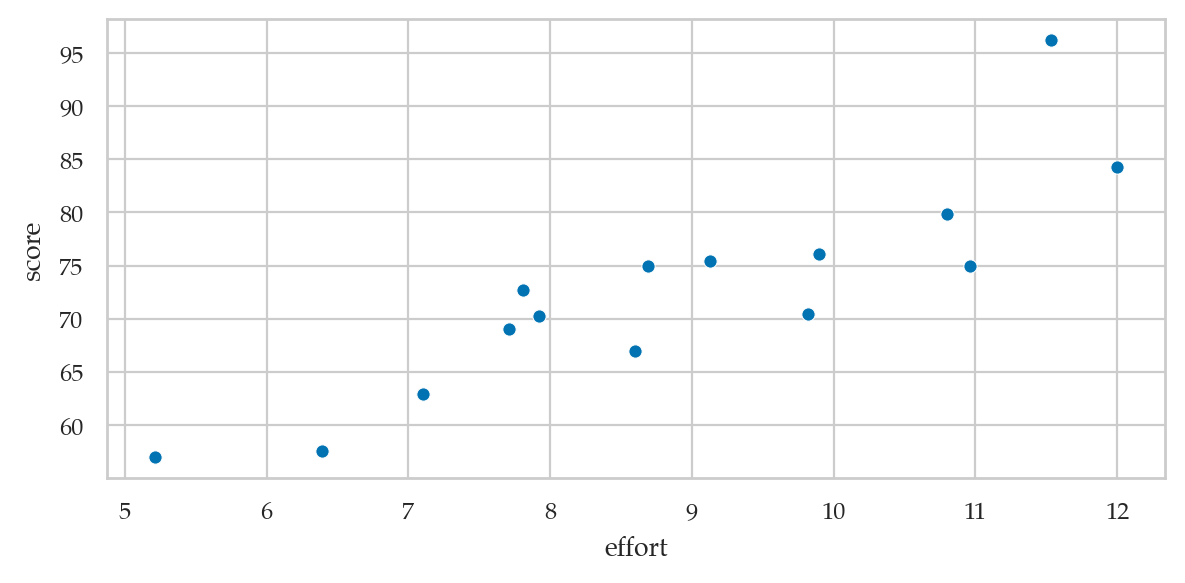

In [8]:
sns.scatterplot(x="effort", y="score", data=students);

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example1_posterior.pdf")
savefigure(plt.gcf(), filename)

### Bayesian model
TODO: add formulas

### Bambi model

In [9]:
#######################################################
priors1 = {
    "Intercept": bmb.Prior("Normal", mu=70, sigma=20),
    "effort": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=20),
}

mod1 = bmb.Model("score ~ 1 + effort",
                 family="gaussian",
                 link="identity",
                 priors=priors1,
                 data=students)
mod1

       Formula: score ~ 1 + effort
        Family: gaussian
          Link: mu = identity
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 70.0, sigma: 20.0)
            effort ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.0)

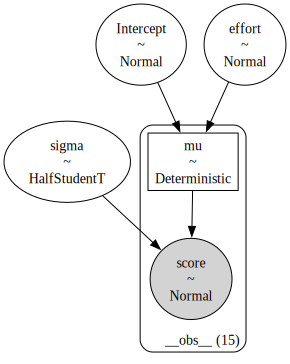

In [10]:
mod1.build()
mod1.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example1_students_mod1_graph")
# mod1.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [11]:
idata1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, effort]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [12]:
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,32.707,6.876,20.245,46.405
effort,4.478,0.750,3.023,5.854
sigma,5.458,1.210,3.440,7.622


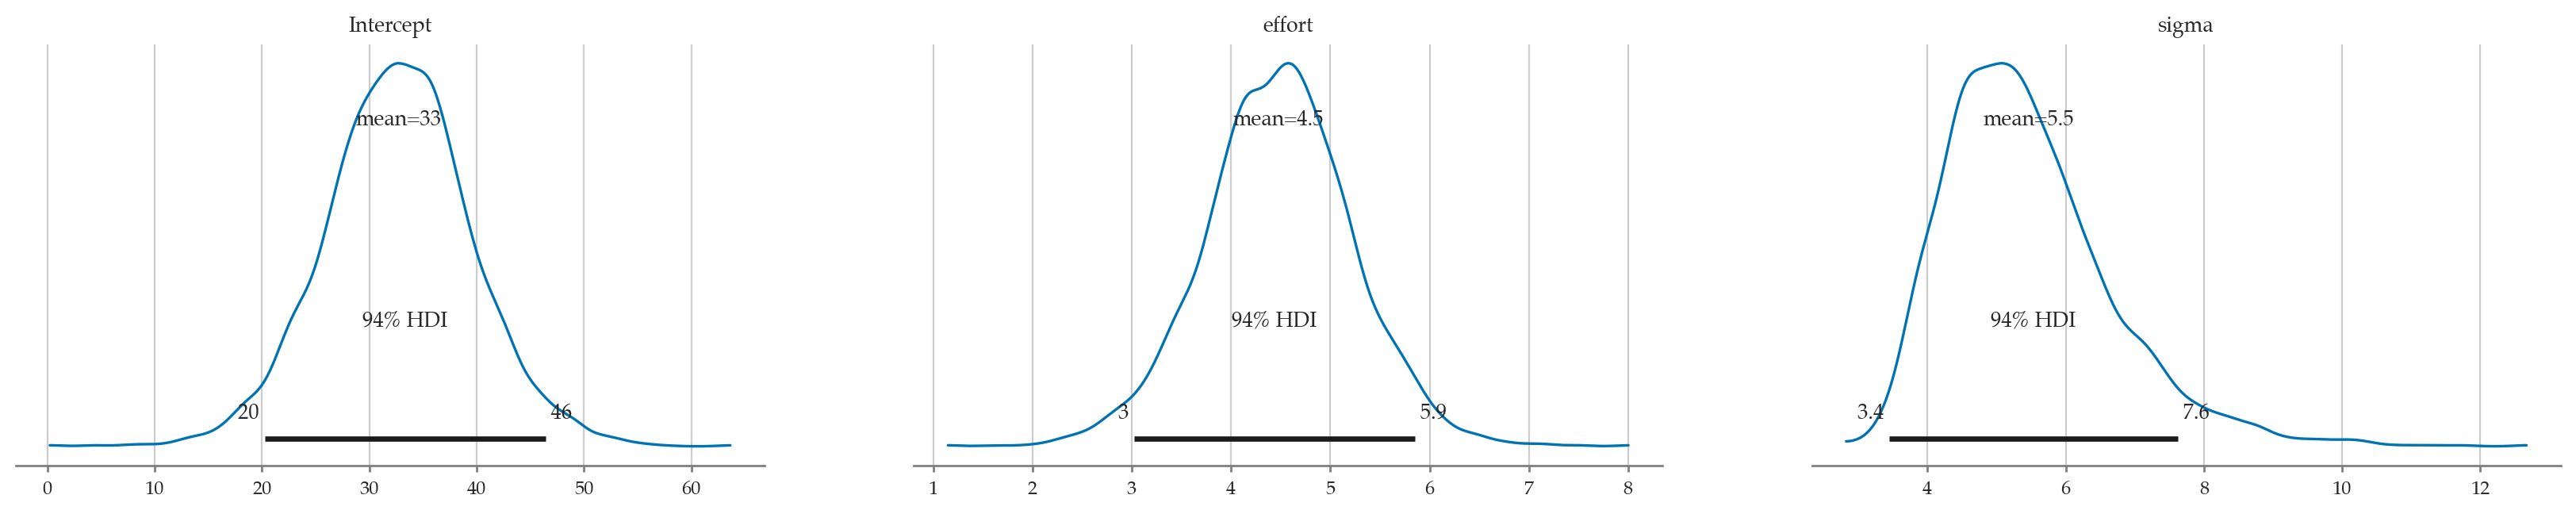

In [13]:
az.plot_posterior(idata1);

Saved figure to figures/bayes/linear/example1_posterior.pdf
Saved figure to figures/bayes/linear/example1_posterior.png


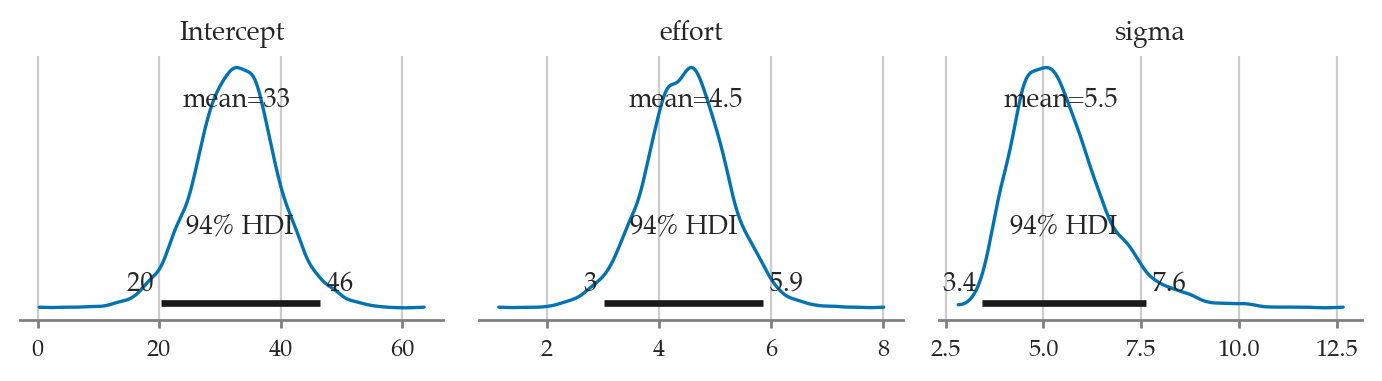

In [14]:
# FIGURES ONLY
az.plot_posterior(idata1, round_to=2, figsize=(7,2));
filename = os.path.join(DESTDIR, "example1_posterior.pdf")
savefigure(plt.gcf(), filename)

In [15]:
# az.plot_ppc(idata1_rep, group="posterior")

Saved figure to figures/bayes/linear/example1_plot_predictions.pdf
Saved figure to figures/bayes/linear/example1_plot_predictions.png


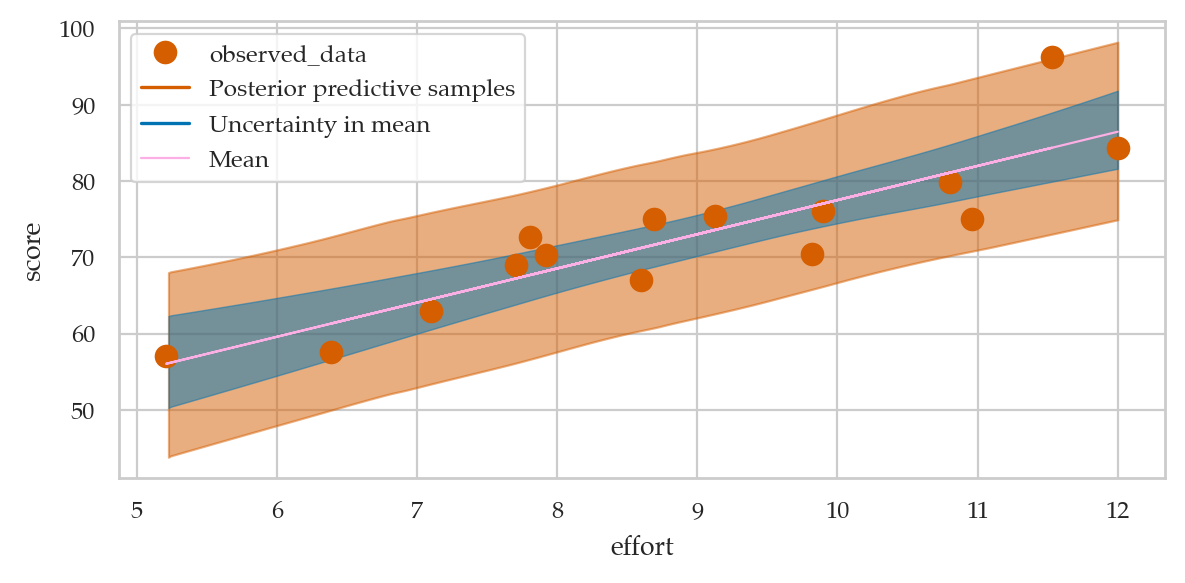

In [16]:
import xarray as xr

# Generate samples form the posterior predictive distribution
idata1_rep = mod1.predict(idata1, inplace=False, kind="response")

# Calculate the model mean
post1 = idata1_rep["posterior"]
efforts = students["effort"]
post1["score_model"] = post1["Intercept"] + post1["effort"] * xr.DataArray(efforts)

# Plot
# az.plot_lm(y="score", idata=idata1, x=efforts);
# az.plot_lm(y="score", idata=idata1, y_model="score_pred", x=efforts);
az.plot_lm(y="score", idata=idata1_rep, y_model="score_model",
           x=efforts, kind_pp="hdi", kind_model="hdi");

# FIGURES ONLY
filename = os.path.join(DESTDIR, "example1_plot_predictions.pdf")
savefigure(plt.gcf(), filename)

### Compare to previous results

In [17]:
# compare with statsmodels results
import statsmodels.formula.api as smf
lm1 = smf.ols("score ~ 1 + effort", data=students).fit()
lm1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.4658,6.155,5.275,0.000,19.169,45.763
effort,4.5049,0.676,6.661,0.000,3.044,5.966


In [18]:
np.sqrt(lm1.scale)

4.929598282660259

### Conclusions

We see effort tends to increase student scores.
The results we obtain from the Bayesian analysis are largely consistent with the frequentist results from Section 4.1,
however Bayesian models allow for simpler interpretation.

## Example 2: doctors sleep scores

### Doctors dataset

In [19]:
doctors = pd.read_csv("../datasets/doctors.csv")
doctors.shape

(156, 9)

In [20]:
doctors.head(3)

,permit,loc,work,hours,caf,alc,weed,exrc,score
0,93273,rur,hos,21,2,0,5.0,0.0,63
1,90852,urb,cli,74,26,20,0.0,4.5,16
2,92744,urb,hos,63,25,1,0.0,7.0,58


In [21]:
doctors[["alc","weed","exrc","score"]].describe().T

,count,mean,std,min,25%,50%,75%,max
alc,156.0,11.839744,9.428506,0.0,3.750,11.0,19.0,44.0
weed,156.0,0.628205,1.391068,0.0,0.000,0.0,0.5,10.5
exrc,156.0,5.387821,4.796361,0.0,0.875,4.5,8.0,19.0
score,156.0,48.025641,20.446294,4.0,33.000,49.5,62.0,97.0


### Bayesian model
TODO: add formulas

### Bambi model

In [22]:
#######################################################
priors2 = {
    "Intercept": bmb.Prior("Normal", mu=50, sigma=40),
    # we'll set the priors for the slopes below
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=20),
}

mod2 = bmb.Model("score ~ 1 + alc + weed + exrc",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=doctors)

# set the same prior for all slopes using `set_priors`
slope_prior = bmb.Prior("Normal", mu=0, sigma=10)
mod2.set_priors(common=slope_prior)

mod2

       Formula: score ~ 1 + alc + weed + exrc
        Family: gaussian
          Link: mu = identity
  Observations: 156
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 50.0, sigma: 40.0)
            alc ~ Normal(mu: 0.0, sigma: 10.0)
            weed ~ Normal(mu: 0.0, sigma: 10.0)
            exrc ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.0)

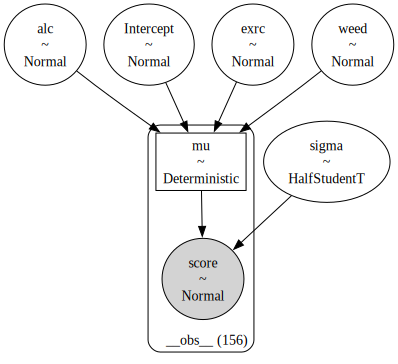

In [23]:
mod2.build()
mod2.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example2_doctors_mod2_graph")
# mod2.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [24]:
idata2 = mod2.fit(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, alc, weed, exrc]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


In [25]:
print(az.summary(idata2, kind="stats"))

             mean     sd  hdi_3%  hdi_97%
Intercept  60.446  1.308  57.956   62.883
alc        -1.800  0.071  -1.935   -1.668
exrc        1.768  0.142   1.500    2.031
sigma       8.268  0.483   7.392    9.188
weed       -1.017  0.481  -1.940   -0.147


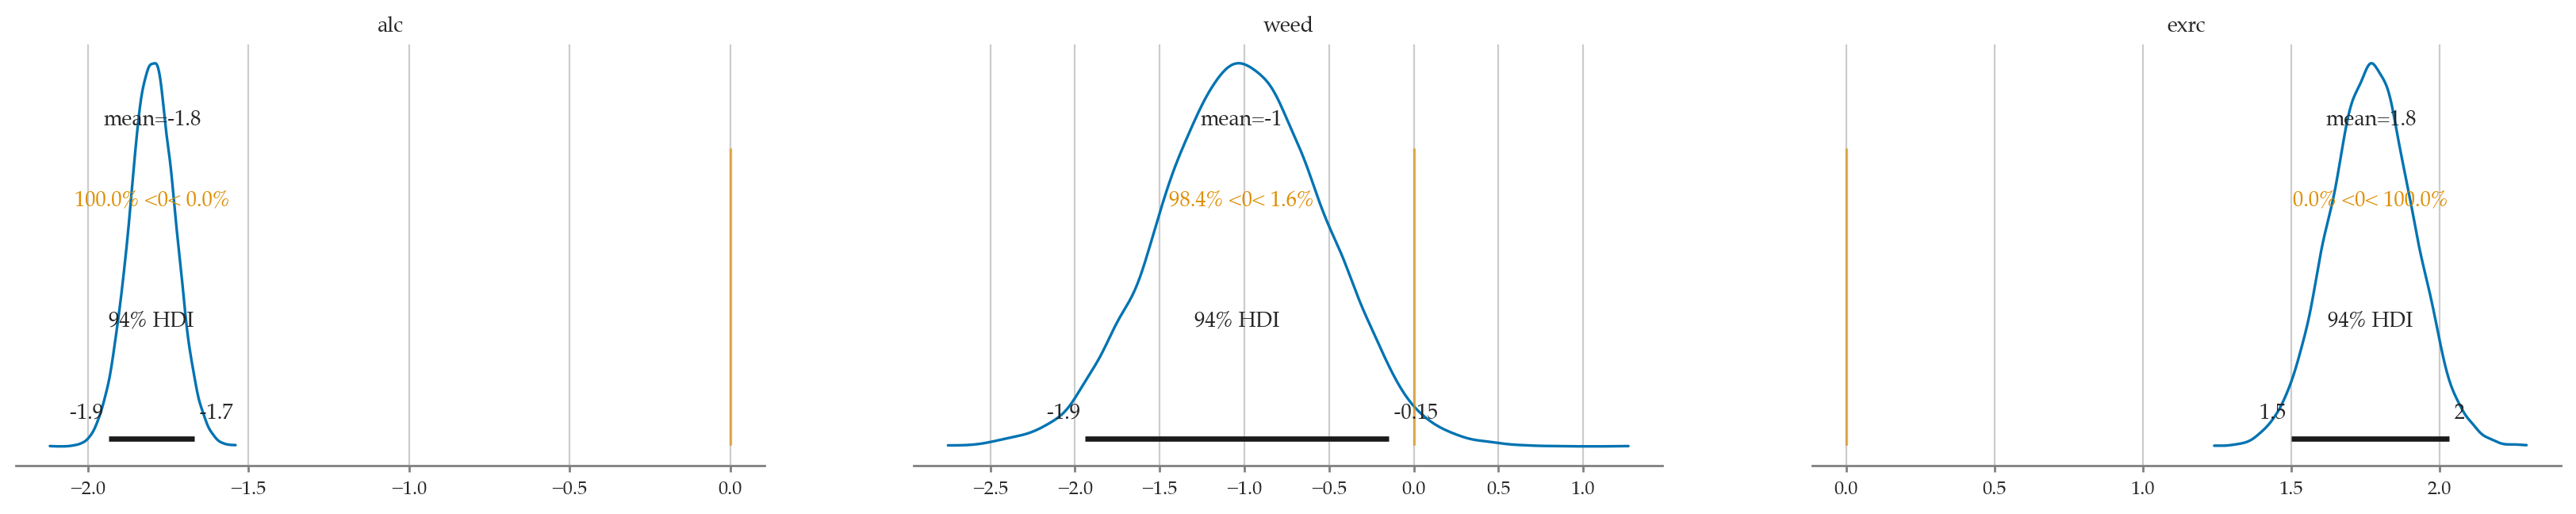

In [26]:
az.plot_posterior(idata2, var_names=["alc", "weed", "exrc"], ref_val=0);

Saved figure to figures/bayes/linear/example2_posterior.pdf
Saved figure to figures/bayes/linear/example2_posterior.png


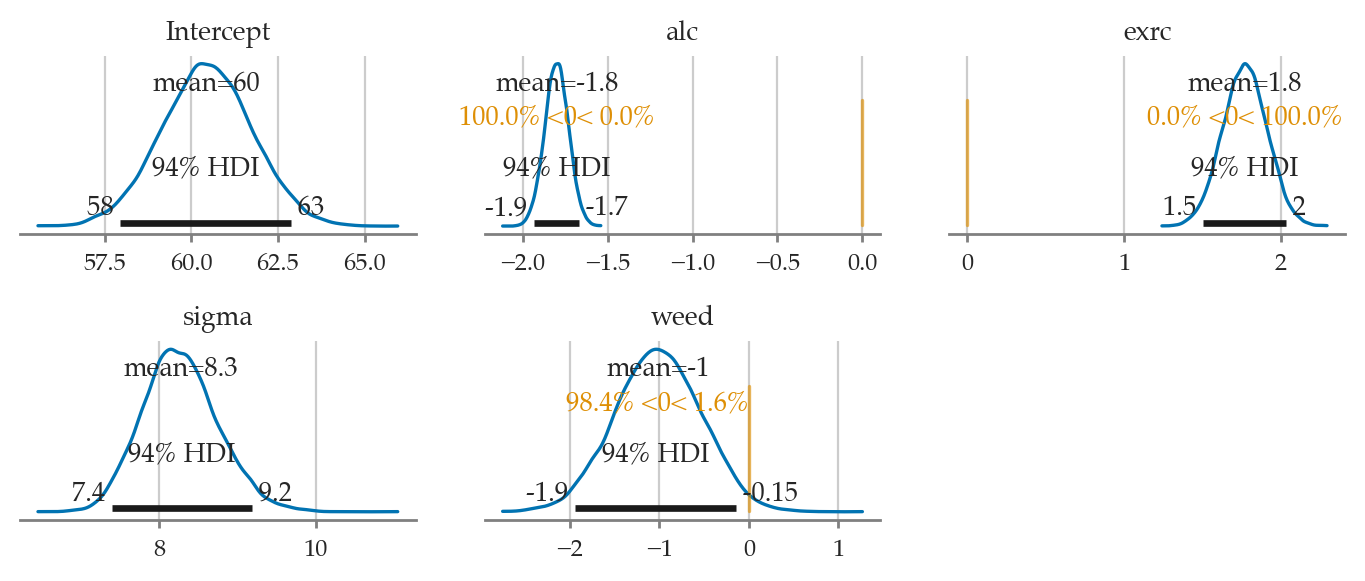

In [27]:
# FIGURES ONLY
ref_vals = {"alc":[{"ref_val":0}],
            "weed":[{"ref_val":0}],
            "exrc":[{"ref_val":0}]}
az.plot_posterior(idata2, round_to=2, ref_val=ref_vals, figsize=(7,3));
filename = os.path.join(DESTDIR, "example2_posterior.pdf")
savefigure(plt.gcf(), filename)

### Partial correlation scale?

cf. https://bambinos.github.io/bambi/notebooks/ESCS_multiple_regression.html#summarize-effects-on-partial-correlation-scale

### Compare to previous results

In [28]:
# compare with statsmodels results
import statsmodels.formula.api as smf
formula = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula, data=doctors).fit()
lm2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.4529,1.289,46.885,0.000,57.905,63.000
alc,-1.8001,0.070,-25.726,0.000,-1.938,-1.662
weed,-1.0216,0.476,-2.145,0.034,-1.962,-0.081
exrc,1.7683,0.138,12.809,0.000,1.496,2.041


In [29]:
np.sqrt(lm2.scale)

8.202768119825624

### Conclusions

## Example 3: Bayesian logistic regression


### Interns data

In [30]:
interns = pd.read_csv("../datasets/interns.csv")
print(interns.head(3))

   work  hired
0  42.5      1
1  39.3      0
2  43.2      1


### Bayesian logistic regression model

### Bambi model

In [31]:
priors3 = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=20),
    "work": bmb.Prior("Normal", mu=0, sigma=2),
}

mod3 = bmb.Model("hired ~ 1 + work",
                 family="bernoulli",
                 link="logit",
                 priors=priors3,
                 data=interns)
mod3

       Formula: hired ~ 1 + work
        Family: bernoulli
          Link: p = logit
  Observations: 100
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 20.0)
            work ~ Normal(mu: 0.0, sigma: 2.0)

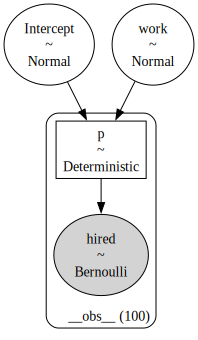

In [32]:
mod3.build()
mod3.graph()

# # FIGURES ONLY
# filename = os.path.join(DESTDIR, "example3_interns_mod3_graph")
# mod3.graph(name=filename, fmt="png", dpi=300)

### Model fitting and analysis

In [33]:
idata3 = mod3.fit()

Modeling the probability that hired==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, work]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [34]:
az.summary(idata3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-82.733,19.489,-119.880,-48.722
work,2.083,0.491,1.225,3.021


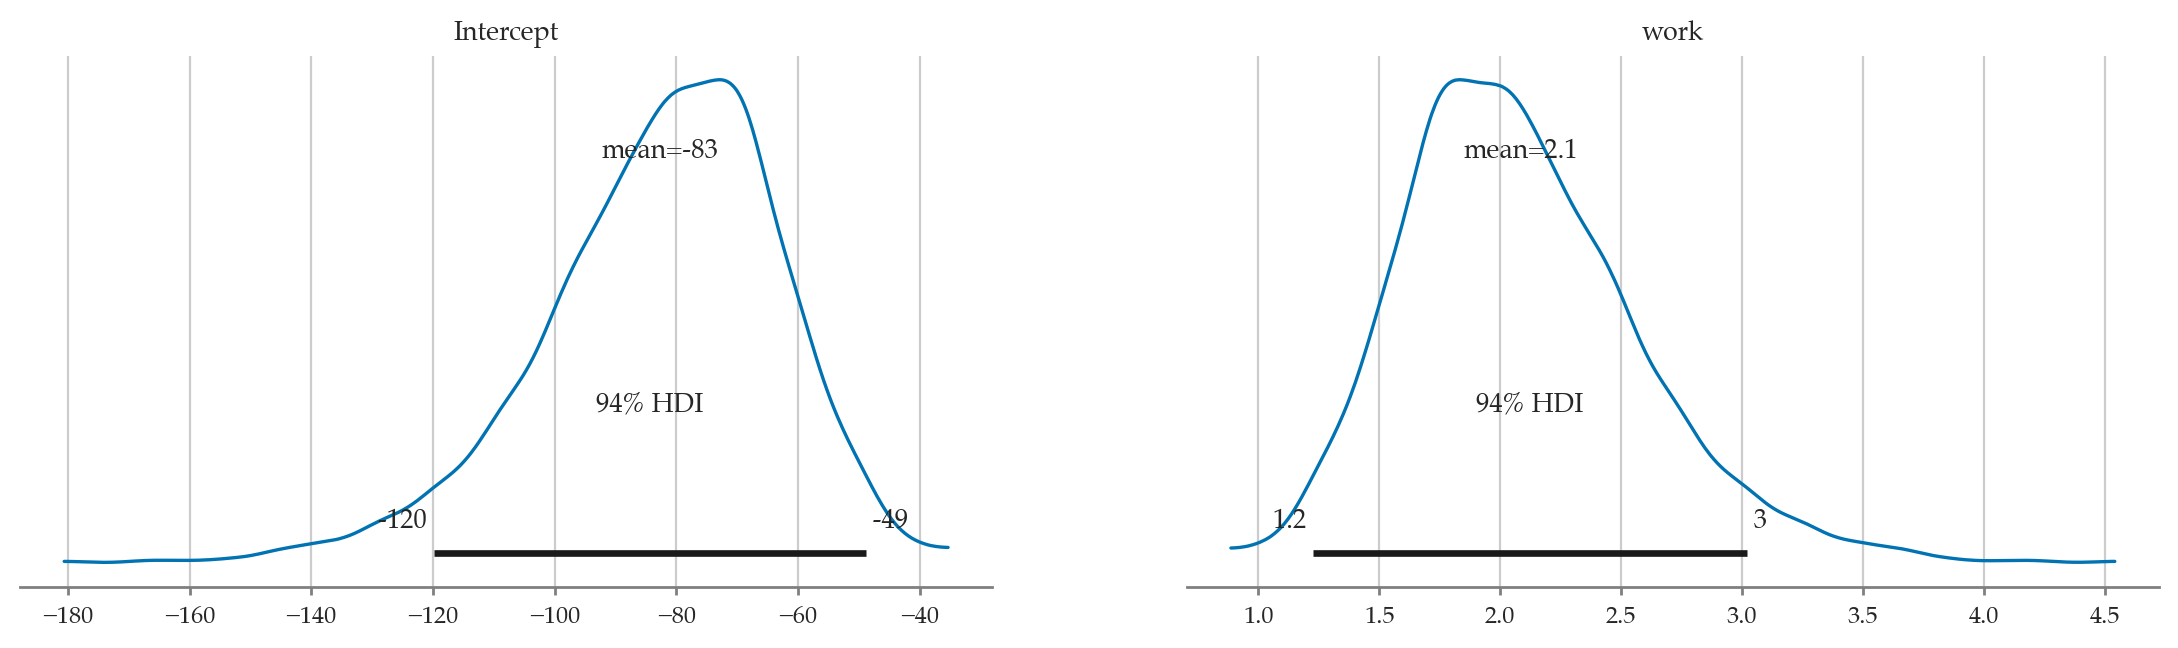

In [35]:
az.plot_posterior(idata3);

Saved figure to figures/bayes/linear/example3_posterior.pdf
Saved figure to figures/bayes/linear/example3_posterior.png


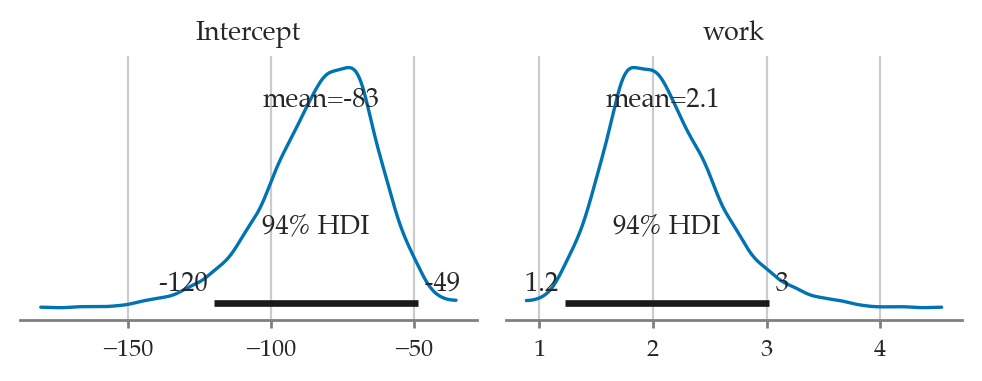

In [36]:
# FIGURES ONLY
az.plot_posterior(idata3, round_to=2, figsize=(5,2));
filename = os.path.join(DESTDIR, "example3_posterior.pdf")
savefigure(plt.gcf(), filename)

### Predictions

In [37]:
import pandas as pd
new_interns = pd.DataFrame({"work": range(20, 60)})
idata3_pred = mod3.predict(idata3, data=new_interns, kind="response", inplace=False)
# idata3
# TODO: try to repdouce 
# https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L181-L193

### Compare with previous results

In [38]:
import statsmodels.formula.api as smf
lr1 = smf.logit("hired ~ 1 + work", data=interns).fit()
print(lr1.params)

Optimization terminated successfully.
         Current function value: 0.138101
         Iterations 10
Intercept   -78.693205
work          1.981458
dtype: float64


### Conclusions

We end up with similar results...

## Explanations

### Shrinkage priors

Shrinkage priors = Prior distributions for a parameter that shrink its posterior estimate towards a particular value.
Sparsity = A situation where most parameter values are zero and only a few are non-zero.

- Laplace priors L1 regularization = lasso regression https://en.wikipedia.org/wiki/Lasso_(statistics)
- Gaussian priors L2 regularization = ridge regression https://en.wikipedia.org/wiki/Ridge_regression
- Reference priors Reference prior ppal pha, beta, sigmaq91{sigma Produces the same results as frequentist linear regression
- Spike-and-slab priors Specialized for spike-and-slab prior = mix- ture of two distributions: one peaked around zero (spike) and the other a diffuse distribution (slab. The spike component identifies the zero elements whereas the slab component captures the non-zero coefficients.

### Standardizing predictors

We make choosing priors easier makes inference more efficient cf. 04_lm/cut_material/standardized_predictors.tex
Robust linear regression


## Discussion

### Comparison to frequentist linear models

- We can obtain similar results
- Bayesian models naturally apply regularization (no need to manually add in)

### Causal graphs

Causal graphs also used with Bayesian LMs (remember Sec 4.5)


### Next steps

- LMs work with categorical predators too, which is what we'll discuss in Section 5.4
- LMs can be extended hierarchical models, which is what we'll discuss in Section 5.5

## Exercises

### Exercise 1: redo some of the exercises/problems from Ch4 using Bayesian methods
### Exercise 2: redo examples of causal inference
### Exercise 3: fit model with different priors
### Exercise 4: redo logistic regression exercises from Sec 4.6

### Exercise 5: bioassay logistic regression

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is death, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Binom}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the LD50, the dosage at which the probability of death is 50%.


via https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section2-PyMC_Intro.ipynb





In [39]:
# Sample size in each group
n = 5

# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Outcomes
deaths = [0, 1, 3, 5]

df_bio = pd.DataFrame({"log_dose":log_dose, "deaths":deaths, "n":n})

In [40]:
# SOLUTION
priors_bio = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "log_dose": bmb.Prior("Normal", mu=0, sigma=5),
}

mod_bio = bmb.Model(formula="p(deaths,n) ~ 1 + log_dose",
                    family="binomial",
                    link="logit",
                    priors=priors_bio,
                    data=df_bio)

idata_bio = mod_bio.fit()

post_bio = idata_bio["posterior"]
post_bio["LD50"] = -post_bio["Intercept"] / post_bio["log_dose"]

az.summary(idata_bio)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, log_dose]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.613,0.777,-0.881,2.050,0.016,0.012,2420.0,2329.0,1.0
log_dose,6.324,2.458,2.334,11.409,0.050,0.038,2676.0,2238.0,1.0
LD50,-0.087,0.136,-0.334,0.181,0.003,0.002,2684.0,2688.0,1.0


### Exercise 6: redo Poisson regression exercises from Sec 4.6
### Exercise 7: fit normal and robust to the dataset ??TODO?? which has outliers


### Exercise 8: PhD delays

cf. https://www.rensvandeschoot.com/tutorials/advanced-bayesian-regression-in-jasp/  
https://zenodo.org/records/3999424  
https://sci-hub.se/https://www.nature.com/articles/ s43586-020-00001-2

## Links

# BONUS MATERIAL

## Simple linear regression on synthetic data

In [41]:
# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

In [42]:
df1 = pd.DataFrame({"x":x, "y":y})

priors1 = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "x": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("HalfNormal", sigma=1),
}

model1 = bmb.Model("y ~ 1 + x",
                   priors=priors1,
                   data=df1)
print(model1)

idata = model1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


       Formula: y ~ 1 + x
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            x ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [Intercept, sigma, x]


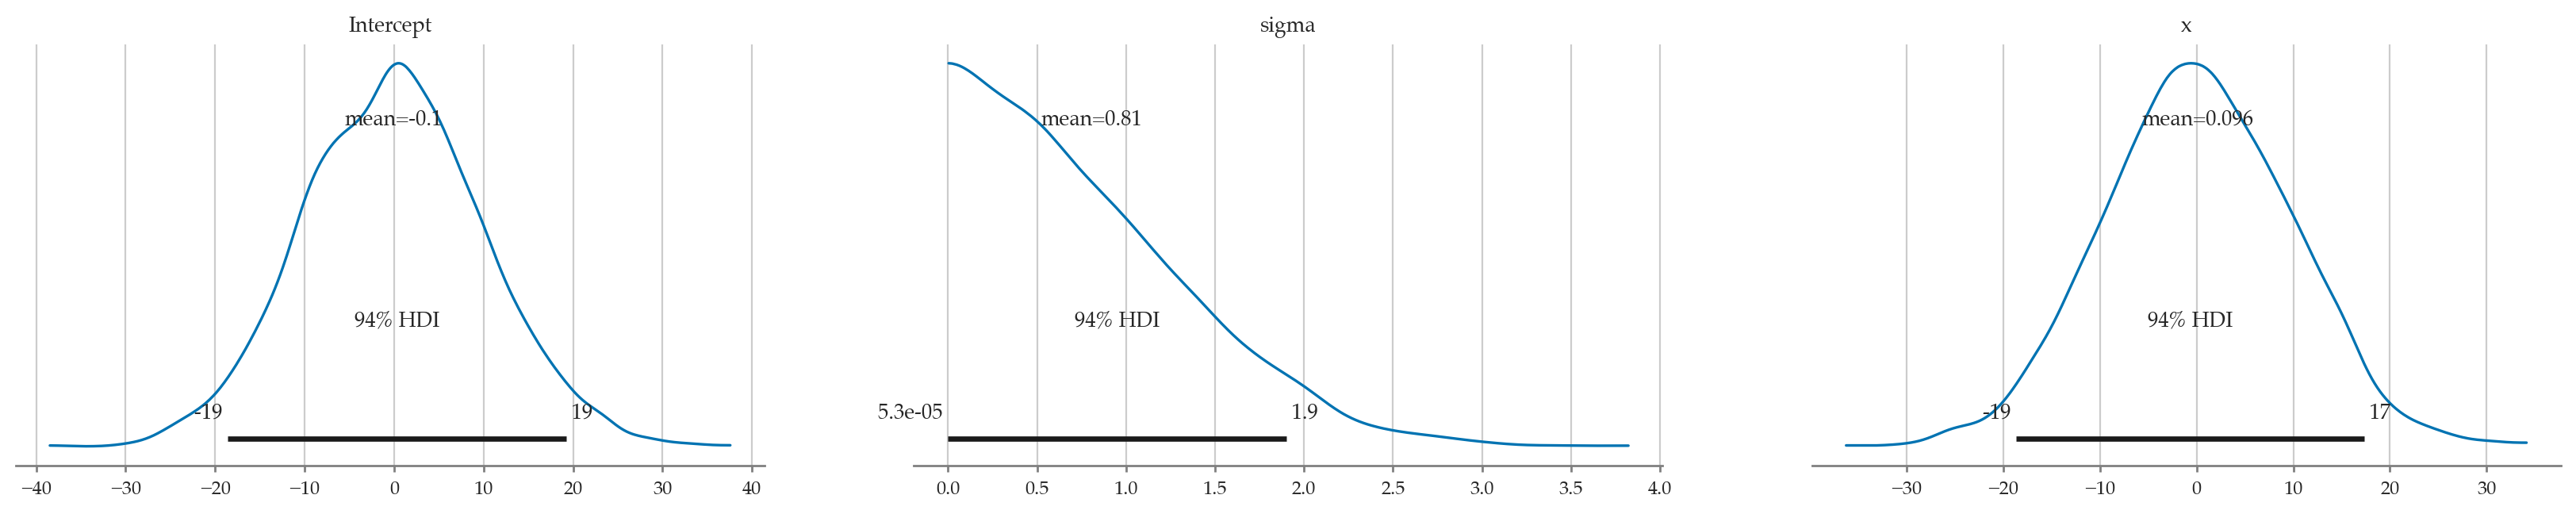

In [43]:
model1.plot_priors();

### Summary using mean


In [44]:
# Posterior Summary
summary = az.summary(idata, kind="stats")
summary

,mean,sd,hdi_3%,hdi_97%
Intercept,3.008,0.097,2.826,3.184
sigma,0.955,0.071,0.827,1.084
x,1.857,0.103,1.658,2.045


### Summary using median as focus statistic

ETI = Equal-Tailed Interval

In [45]:
az.summary(idata, stat_focus="median", kind="stats")

,median,mad,eti_3%,eti_97%
Intercept,3.005,0.066,2.831,3.190
sigma,0.951,0.049,0.835,1.095
x,1.855,0.070,1.669,2.056


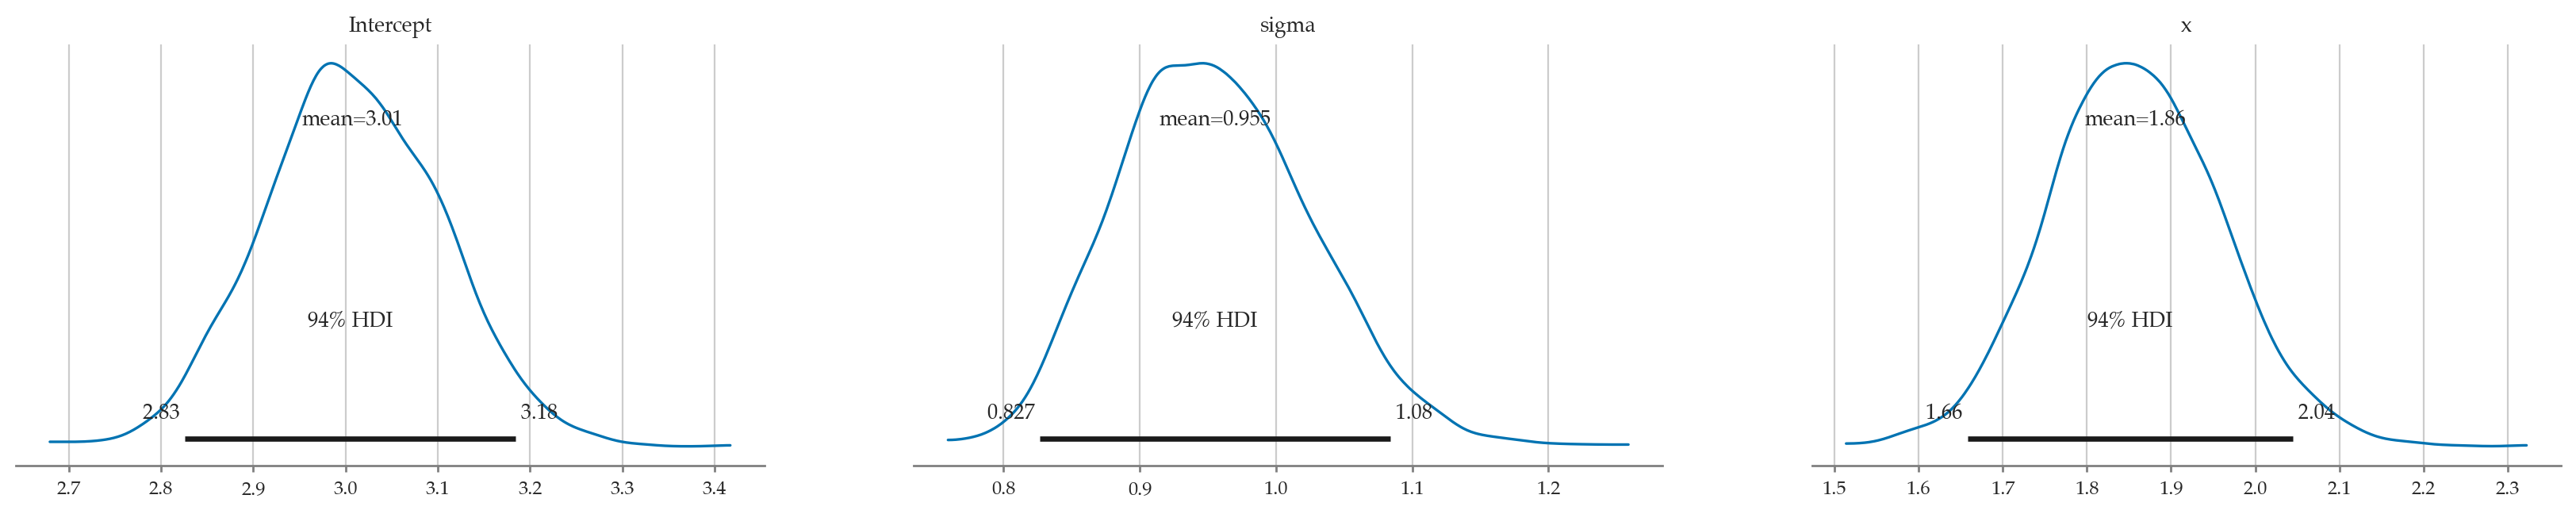

In [46]:
# Plotting posterior
az.plot_posterior(idata, point_estimate="mean", round_to=3);

Investigare further

https://python.arviz.org/en/latest/api/generated/arviz.plot_lm.html

In [47]:
# az.plot_lm(idata)

### Simple linear regression using PyMC

In [48]:
import pymc as pm

In [49]:
# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

In [50]:
# Bayesian Linear Regression Model
with pm.Model() as pmmodel:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    idata = pm.sample()

az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,3.007,0.096,2.827,3.189,0.001,0.001,5111.0,3169.0,1.0
beta1,1.855,0.108,1.653,2.062,0.001,0.001,6067.0,2833.0,1.0
sigma,0.957,0.070,0.827,1.084,0.001,0.001,5840.0,2865.0,1.0


## Bonus Bayesian logistic regression example

via [file:///Users/ivan/Downloads/talks-main/pydataglobal21/index.html#15](/Users/ivan/Downloads/talks-main/pydataglobal21/index.html#15)

via https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L123

In [51]:
import bambi as bmb
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [52]:
model = bmb.Model("vote[clinton] ~ 0 + party_id + party_id:age", data, family="bernoulli")
print(model)

idata = model.fit()

Modeling the probability that vote==clinton


       Formula: vote[clinton] ~ 0 + party_id + party_id:age
        Family: bernoulli
          Link: p = logit
  Observations: 421
        Priors: 
    target = p
        Common-level effects
            party_id ~ Normal(mu: [0. 0. 0.], sigma: [1. 1. 1.])
            party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0586 0.0586 0.0586])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [party_id, party_id:age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [53]:
import pandas as pd
new_subjects = pd.DataFrame({"age": [20, 60], "party_id": ["independent"] * 2})
model.predict(idata, data=new_subjects)

# TODO: try to repdouce 
# https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L181-L193

## Bayesian Linear Regression (BONUS)

from [cs109b_lect13_bayes_2_2021.ipynb](./explorations/cs109b_lect13_bayes_2_2021.ipynb)


We will artificially create the data to predict on. We will then see if our model predicts them correctly.

In [54]:
np.random.seed(123)

######## True parameter values 
##### our model does not see these
sigma = 1
beta0 = 1
beta = [1, 2.5]   
###############################
# Size of dataset
size = 100

# Feature variables
x1 = np.linspace(0, 1., size)
x2 = np.linspace(0,2., size)

# Create outcome variable with random noise
Y = beta0 + beta[0]*x1 + beta[1]*x2 + np.random.randn(size)*sigma

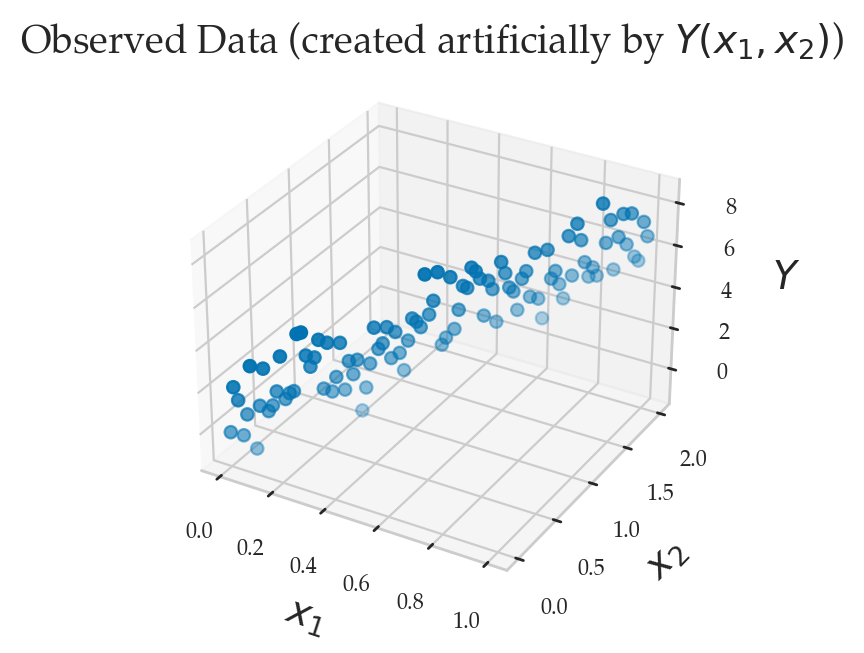

In [55]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fontsize=14
labelsize=8
title='Observed Data (created artificially by ' + r'$Y(x_1,x_2)$)'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y)
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.set_zlabel(r'$Y$', fontsize=fontsize)

ax.tick_params(labelsize=labelsize)

fig.suptitle(title, fontsize=fontsize)        
fig.tight_layout(pad=.1, w_pad=10.1, h_pad=2.)
#fig.subplots_adjust(); #top=0.5
plt.tight_layout
plt.show()

Now let's see if our model will correctly predict the values for our unknown parameters, namely $b_0$, $b_1$, $b_2$ and $\sigma$.

#### Defining the Problem

Our problem is the following: we want to perform multiple linear regression to predict an outcome variable $Y$ which depends on variables $\bf{x}_1$ and $\bf{x}_2$.

We will model $Y$ as normally distributed observations with an expected value $mu$ that is a linear function of the two predictor variables, $\bf{x}_1$ and $\bf{x}_2$.

\begin{equation}
Y \sim  \mathcal{N}(\mu,\,\sigma^{2})
\end{equation} 

\begin{equation}
\mu = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 x_2 
\end{equation}

where $\sigma^2$ represents the measurement error (in this example, we will use $\sigma^2 = 10$)

We also choose the parameters to have normal distributions with those parameters set by us.

\begin{eqnarray}
\beta_i \sim  \mathcal{N}(0,\,10) \\
\sigma^2 \sim  |\mathcal{N}(0,\,10)|
\end{eqnarray}   

<a id=model></a>


#### Defining a Model in PyMC3

In [56]:
with pm.Model() as my_linear_model:

    # Priors for unknown model parameters, specifically created stochastic random variables 
    # with Normal prior distributions for the regression coefficients,
    # and a half-normal distribution for the standard deviation of the observations.
    # These are our parameters. P(theta)

    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    # Note: betas is a vector of two variables, b1 and b2, (denoted by shape=2)
    # so, in array notation, our beta1 = betas[0], and beta2=betas[1]
    betas = pm.Normal('betas', mu=0, sigma=10, shape=2) 
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # mu is what is called a deterministic random variable, which implies that its value is completely
    # determined by its parents’ values (betas and sigma in our case). 
    # There is no uncertainty in the variable beyond that which is inherent in the parents’ values
    
    mu = beta0 + betas[0]*x1 + betas[1]*x2
    
    # Likelihood function = how probable is my observed data?
    # This is a special case of a stochastic variable that we call an observed stochastic.
    # It is identical to a standard stochastic, except that its observed argument, 
    # which passes the data to the variable, indicates that the values for this variable were observed, 
    # and should not be changed by any fitting algorithm applied to the model. 
    # The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

**Note**: If our problem was a classification for which we would use Logistic regression see [below](#LR) <BR>
    
**Python Note**: `pm.Model` is designed as a simple API that abstracts away the details of the inference. For the use of `with` see [Compounds statements in Python.](https://docs.python.org/3/reference/compound_stmts.html).

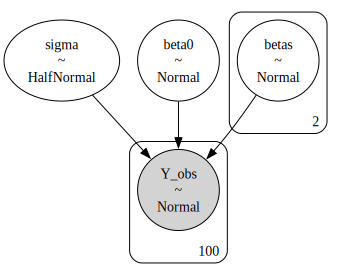

In [57]:
## do not worry about this, it's just a nice graph to have
## you need to install python-graphviz first
# conda install -c conda-forge python-graphviz
pm.model_to_graphviz(my_linear_model)

#### Fitting the Model with Sampling - Doing Inference

See below for PyMC3's sampling method. As you can see it has quite a few parameters. Most of them are set to default values by the package. For some, it's useful to set your own values.
```
pymc3.sampling.sample(draws=500, step=None, n_init=200000, chains=None, 
                      cores=None, tune=500, random_seed=None)
```

Parameters to set:

- **draws**: (int): Number of samples to keep when drawing, defaults to 500. Number starts after the tuning has ended. 
- **tune**: (int): Number of iterations to use for tuning the model, also called the burn-in period, defaults to 500. Samples from the tuning period will be discarded.
- **target_accept** (float in $[0, 1]$). The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors.
- (optional) **chains** (int) number of chains to run in parallel, defaults to the number of CPUs in the system, but at most 4.

`pm.sample` returns a `pymc3.backends.base.MultiTrace` object that contains the samples. We usually name it a variation of the word `trace`. All the information about the posterior is in `trace`, which also provides statistics about the sampler.

#### How does a good trace plot look like? Is this a good one?

<img src="images/trace.png" width="700px">

In [58]:
## uncomment this to see more about pm.sample
#help(pm.sample)

In [59]:
with my_linear_model:
    print(f'Starting MCMC process')
    # draw nsamples posterior samples and run the default number of chains = 4 
    nsamples = 1000 # number of samples to keep
    burnin = 1000 # burnin period
    trace = pm.sample(nsamples, tune=burnin, target_accept=0.8) 
    print(f'DONE')

Starting MCMC process


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


DONE


In [60]:
var_names = trace["posterior"].data_vars
# # var_names = var_names.remove('sigma_log__')
var_names = ["beta0", "sigma"]

#### Model Plotting

PyMC3 provides a variety of visualizations via plots: [https://docs.pymc.io/api/plots.html](https://docs.pymc.io/api/plots.html). `arviz` is another library that you can use.

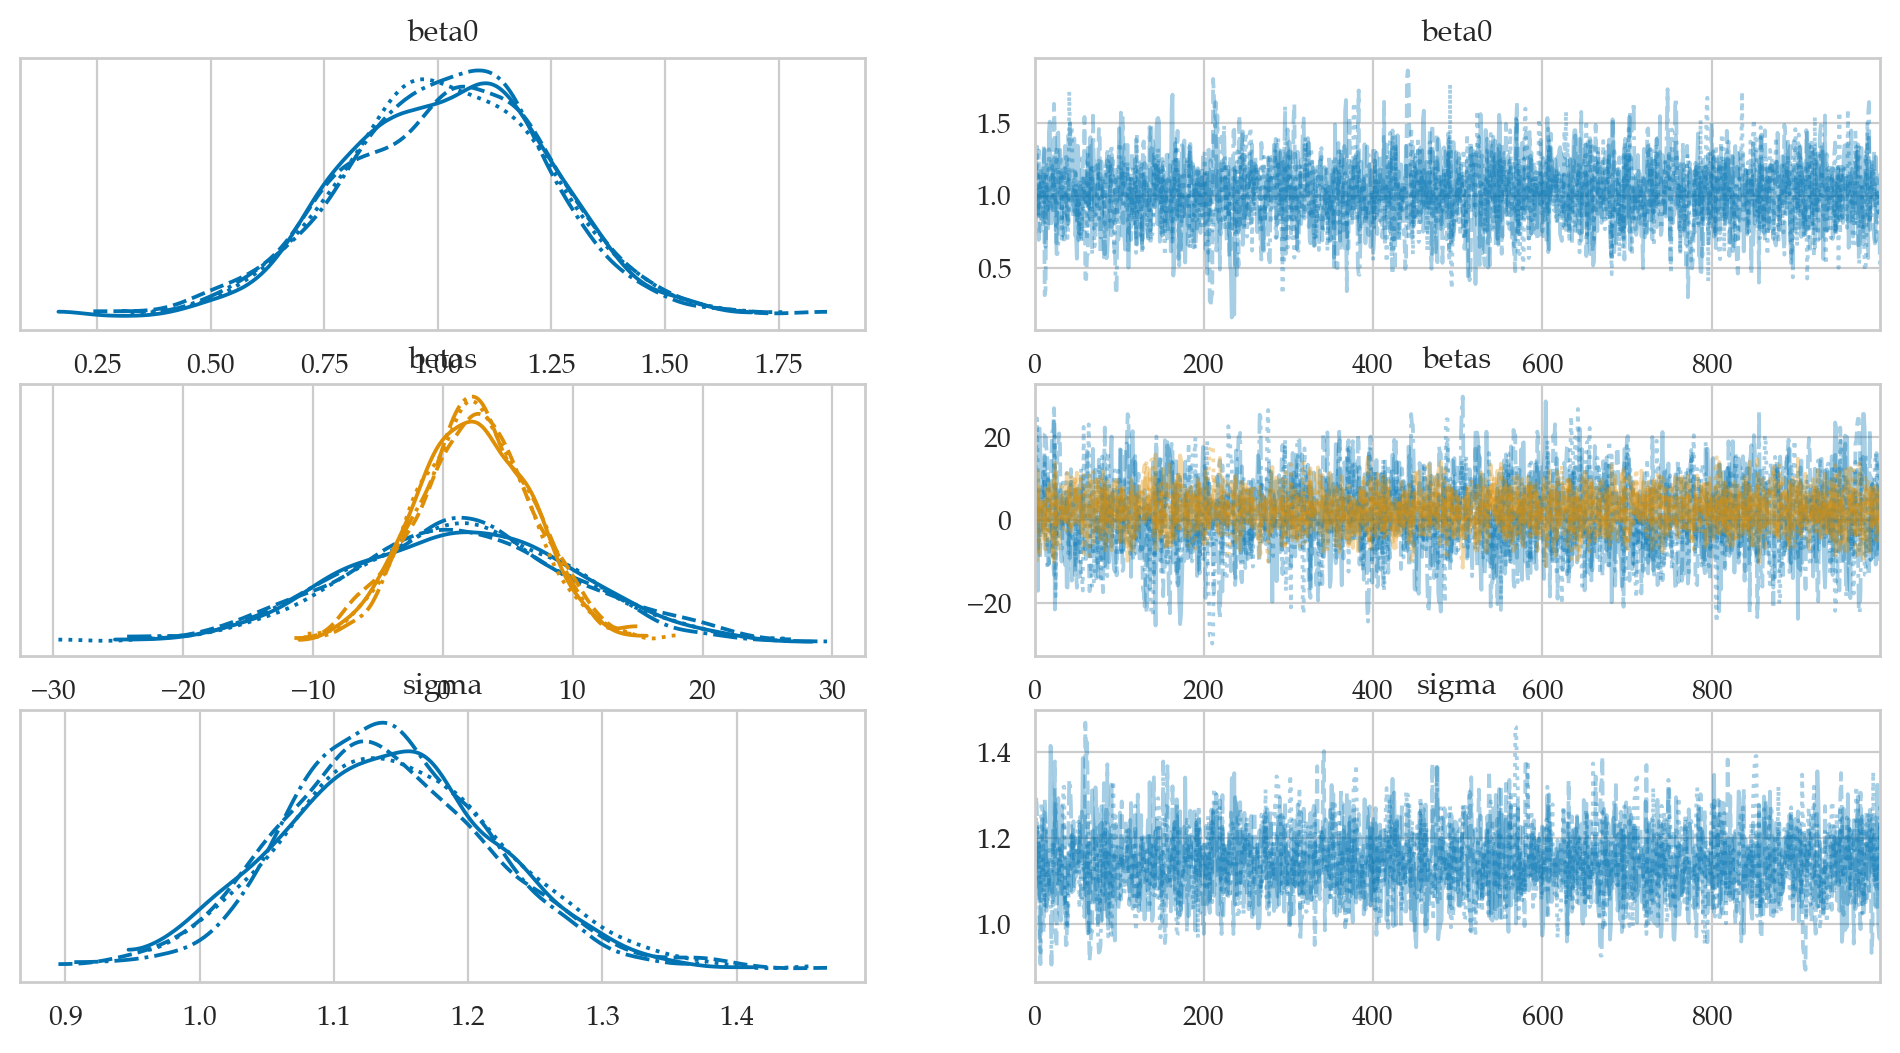

In [61]:
az.plot_trace(trace);

In [62]:
# generate results table from trace samples
# remember our true hidden values sigma = 1, beta0 = 1, beta = [1, 2.5] 
# We want R_hat < 1.1
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.019,0.228,0.606,1.456,0.004,0.003,2674.0,2270.0,1.0
betas[0],1.197,8.929,-16.244,17.598,0.220,0.161,1645.0,1823.0,1.0
betas[1],2.412,4.467,-6.284,10.655,0.110,0.078,1640.0,1717.0,1.0
sigma,1.142,0.080,0.993,1.290,0.002,0.001,2321.0,2081.0,1.0


In [63]:
#help(pm.Normal)

$\hat{R}$ is a metric for comparing how well a chain has converged to the equilibrium distribution by comparing its behavior to other randomly initialized Markov chains. Multiple chains initialized from different initial conditions should give similar results.
If all chains converge to the same equilibrium, $\hat{R}$ will be 1. If the chains have not converged to a common distribution, $\hat{R}$ will be > 1.01. $\hat{R}$ is a necessary but not sufficient condition.

For details on the $\hat{R}$ see *Gelman and Rubin (1992)*. 

This linear regression example is from the original paper on PyMC3: *Salvatier J, Wiecki TV, Fonnesbeck C. 2016. Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55*